In [1]:
# env: torch_gpu_py311
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# don't pre-allocate memory; allocate as-needed
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# import deepsensor.torch
import deepsensor.data.processor as dp
from deepsensor.data.loader import TaskLoader

# from gpytorch.kernels import RBFKernel, ScaleKernel
# from deepsensor.model.convnp import ConvNP
# from deepsensor.train.train import Trainer

import jax
import jax.numpy as jnp
import optax
from tinygp import GaussianProcess, kernels

import matplotlib.pyplot as plt

<Axes: >

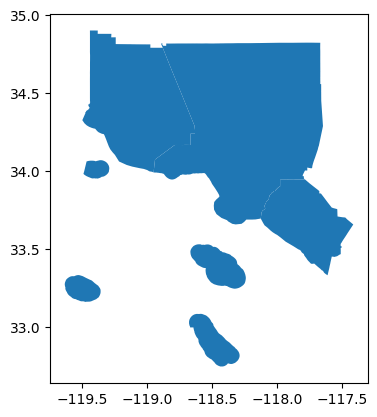

In [2]:
cal_shape = gpd.read_file("/home/patel_zeel/aqmsp/aqmsp_data/datasets/shapefiles/california/CA_Counties_TIGER2016.shp")
cal_shape = cal_shape.to_crs("EPSG:4326")

cities = ["Los Angeles", "Orange", "Ventura"]
city_shape = cal_shape[cal_shape["NAME"].isin(cities)]
city_shape.plot()

In [3]:
base_path = "/home/patel_zeel/OpenAQ/PurpleAir/purpleair_california.nc"
ds = xr.open_dataset(base_path, chunks="auto").load()
ds['location_id'] = ds['location_id'].astype(str)

# city_ds
city_ds = xr.open_dataset(os.path.join("../data/", "_".join(cities)) + ".nc", chunks="auto")

ds = ds.sel(location_id=city_ds.location_id.values, datetime=slice("2021-06-01", "2021-08-01"))
ds

<xarray.Dataset>
Dimensions:      (datetime: 1488, location_id: 493)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2021-06-01 ... 2021-08-01T23:00:00
  * location_id  (location_id) <U21 '62194' '62203' ... '227551' '227806'
    lat          (location_id) float64 34.07 33.86 33.84 ... 34.07 34.07 34.0
    lon          (location_id) float64 -118.2 -118.4 -118.3 ... -118.2 -118.1
Data variables:
    value        (datetime, location_id) float64 48.81 11.53 14.8 ... 7.326 6.9

## Some exploration

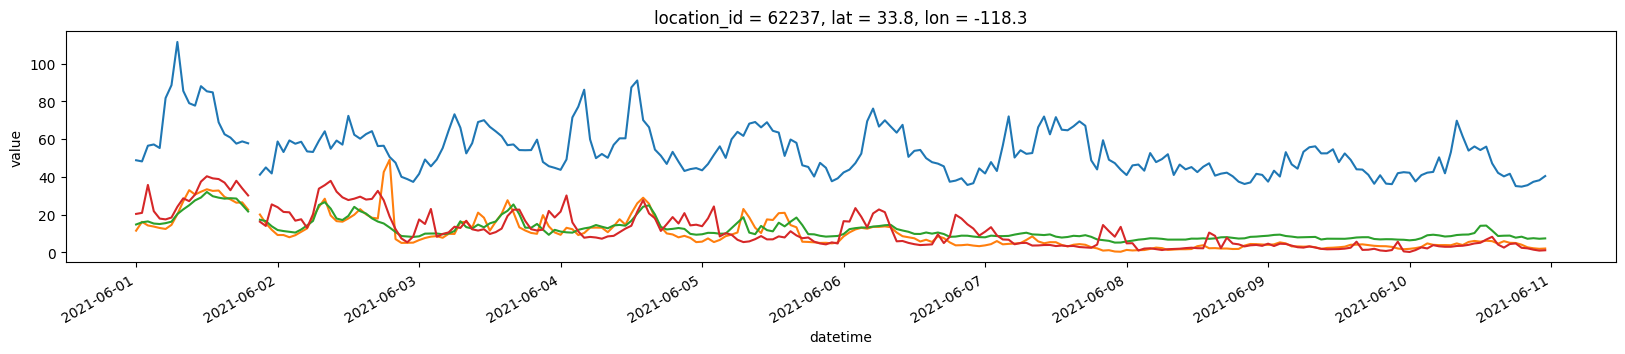

In [4]:
random_locations = ds.location_id.values[0:4]

fig, ax = plt.subplots(figsize=(20, 3))
for random_location in random_locations:
    ds.sel(location_id=random_location, datetime=slice("2021-06-01", "2021-06-10"))['value'].plot(ax=ax)

## Clean up the data

Remove the time-stamps with massively missing data

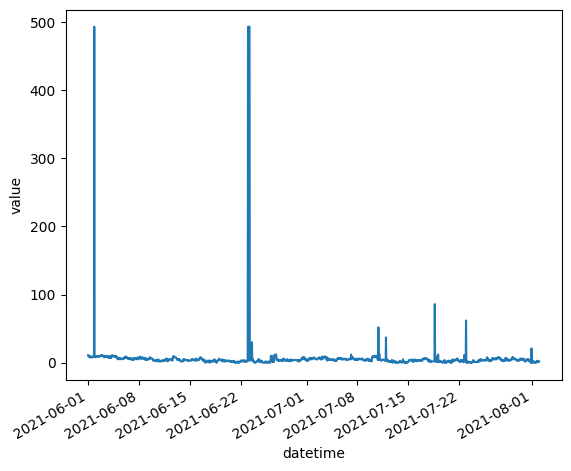

In [5]:
missing_locations = ds.isnull().sum(dim="location_id")['value']
missing_locations.plot();

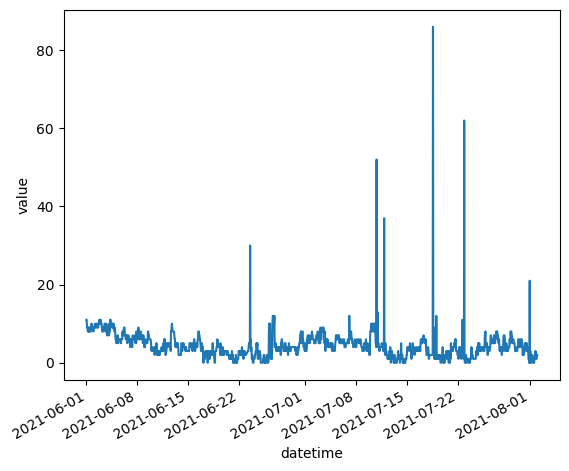

In [6]:
first_clean_ds = missing_locations[missing_locations < 200]
first_clean_ds.plot();

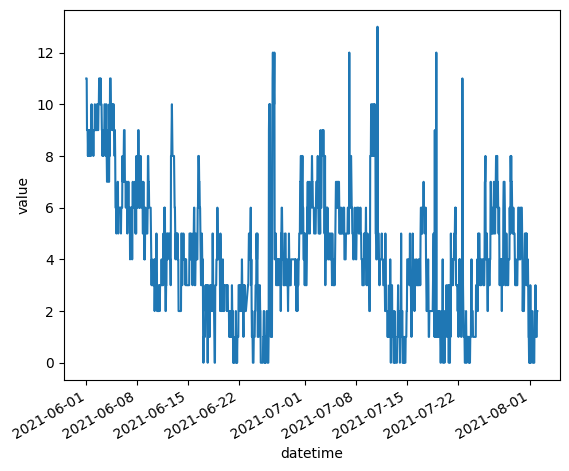

In [7]:
second_clean_ds = missing_locations[missing_locations < 20]
second_clean_ds.plot();

In [8]:
clean_datetime_ds = ds.sel(datetime=second_clean_ds.datetime.values)
clean_datetime_ds

<xarray.Dataset>
Dimensions:      (datetime: 1475, location_id: 493)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2021-06-01 ... 2021-08-01T23:00:00
  * location_id  (location_id) <U21 '62194' '62203' ... '227551' '227806'
    lat          (location_id) float64 34.07 33.86 33.84 ... 34.07 34.07 34.0
    lon          (location_id) float64 -118.2 -118.4 -118.3 ... -118.2 -118.1
Data variables:
    value        (datetime, location_id) float64 48.81 11.53 14.8 ... 7.326 6.9

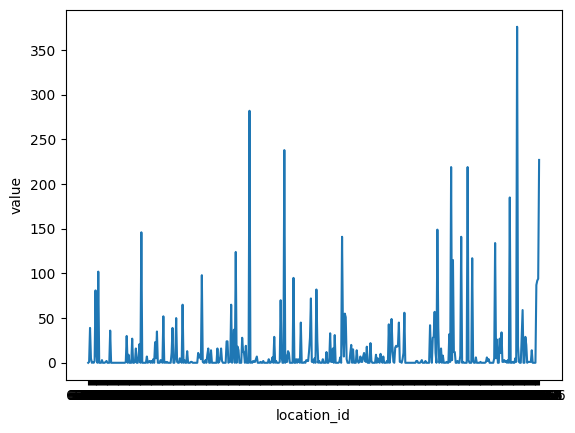

In [9]:
missing_times = clean_datetime_ds.isnull().sum(dim="datetime")
missing_times['value'].plot()

(493,)
(458,)


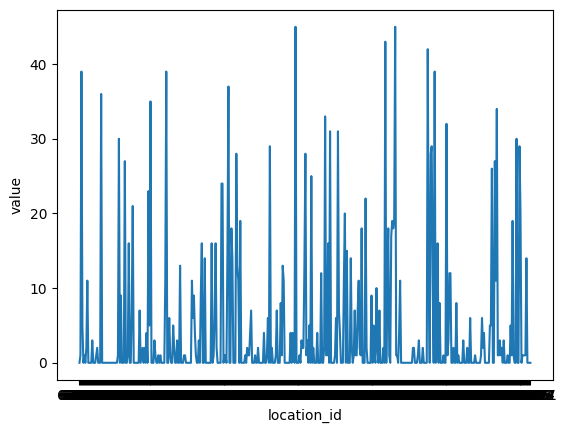

In [10]:
print(missing_times.location_id.shape)
first_clean_ds_2 = missing_times['value'][missing_times['value'] < 48]
print(first_clean_ds_2.location_id.shape)
first_clean_ds_2.plot();

Random checks

Missing times <xarray.Dataset>
Dimensions:      ()
Coordinates:
    location_id  <U21 '66355'
    lat          float64 33.78
    lon          float64 -118.4
Data variables:
    value        int64 282


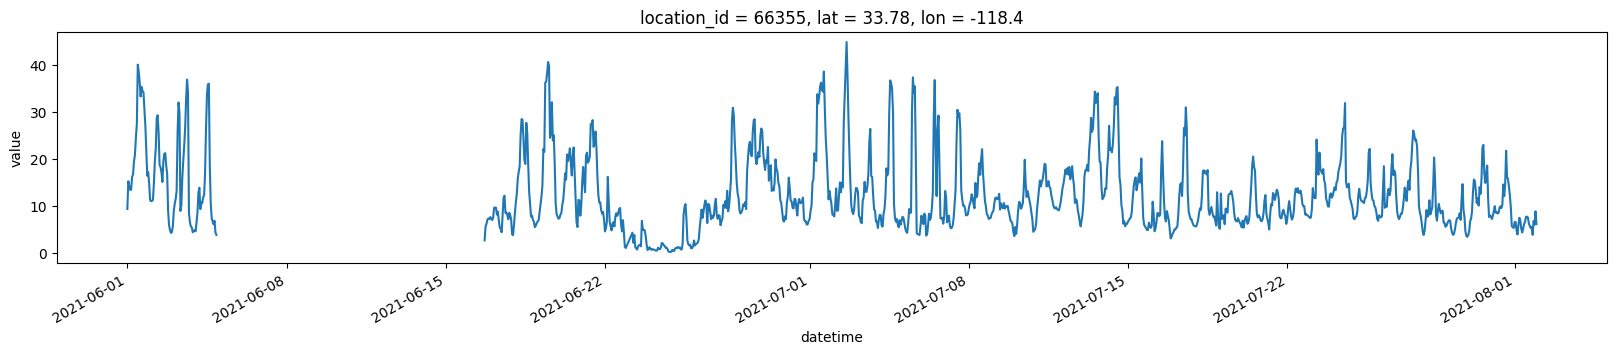

In [11]:
random_location = missing_times.sortby("value", ascending=False).location_id.values[1]
# random_location
print("Missing times", missing_times.sel(location_id=random_location))
clean_datetime_ds.sel(location_id=random_location)['value'].plot(figsize=(20, 3));

In [12]:
print("All locations", ds.location_id.values.shape)
print("All datetimes", ds.datetime.values.shape)
clean_datetimes = clean_datetime_ds.datetime.values
clean_locations = first_clean_ds_2.location_id.values
len(clean_datetimes), len(clean_locations)

All locations (493,)
All datetimes (1488,)


(1475, 458)

In [13]:
clean_ds = ds.sel(location_id=clean_locations, datetime=clean_datetimes)

min_lat, max_lat = clean_ds.lat.min().item(), clean_ds.lat.max().item()
min_lon, max_lon = clean_ds.lon.min().item(), clean_ds.lon.max().item()
mean_val = clean_ds.value.mean().item()
std_val = clean_ds.value.std().item()

clean_ds["lat"] = (clean_ds.lat - min_lat) / (max_lat - min_lat)
clean_ds["lon"] = (clean_ds.lon - min_lon) / (max_lon - min_lon)
clean_ds["value"] = (clean_ds.value - mean_val) / std_val

## Settings

* Hold out half of the data for testing.
* Use 50 sensors for initial training and keep the rest in the pool.
* Train for a month of data. Place sensors using 15 days and evaluate the model for remaining 15 days.
* We evaluate over the next month.

## Train pool test split

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


50 208 200


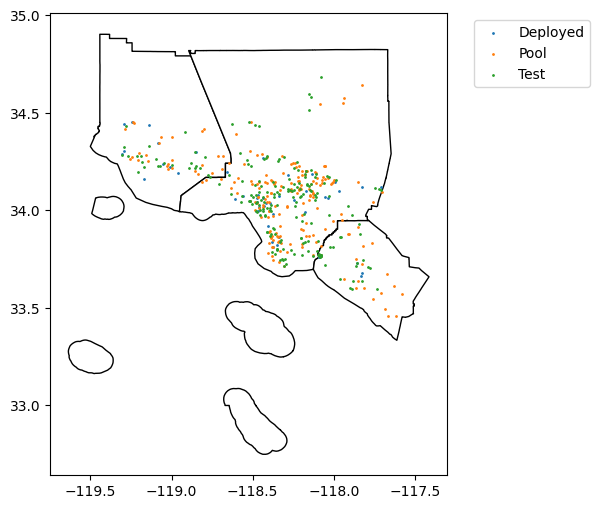

In [14]:
seed = 42
all_locations = clean_ds.location_id.values
deployed_pool_locations, test_locations = train_test_split(all_locations, test_size=200, random_state=seed)
deployed_locations, pool_locations = train_test_split(deployed_pool_locations, train_size=50, random_state=seed)
print(len(deployed_locations), len(pool_locations), len(test_locations))

# train_ds = clean_ds.sel(location_id=train_locations, datetime=slice("2021-06-01", "2021-07-01"))
# pool_ds = clean_ds.sel(location_id=datetime=slice("2021-07-01", "2021-07-15"))
# test_ds = clean_ds.sel(datetime=slice("2021-07-15", "2021-08-01"))

fig, ax = plt.subplots(figsize=(10, 6))
def plot_locations(locations, ax, label):
    tmp_ds = clean_ds.sel(location_id=locations)
    lons = tmp_ds.lon.values * (max_lon - min_lon) + min_lon
    lats = tmp_ds.lat.values * (max_lat - min_lat) + min_lat
    ax.scatter(lons, lats, label=label, s=1)
city_shape.plot(ax=ax, color="white", edgecolor="black")

plt.legend(bbox_to_anchor=(1.05, 1))
plot_locations(deployed_locations, ax, "Deployed")
plot_locations(pool_locations, ax, "Pool")
plot_locations(test_locations, ax, "Test")

plt.legend(bbox_to_anchor=(1.05, 1))

Verify sufficient data in train for any given day.

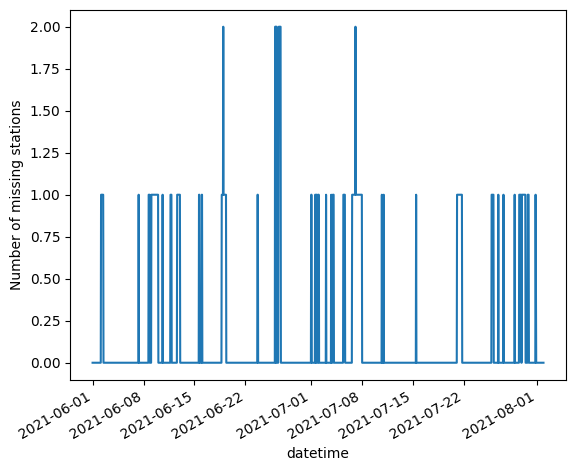

In [15]:
clean_ds.sel(location_id=deployed_locations).isnull().sum(dim="location_id")['value'].plot();
plt.ylabel("Number of missing stations");

In [16]:
def get_gp(params, X):
    scale = jnp.exp(params["log_scale"])
    var = jnp.exp(params["log_var"])
    noise_var = jnp.exp(params["log_noise_var"])
    
    kernel = kernels.Matern52(scale=scale) * var
    gp = GaussianProcess(kernel=kernel, diag=noise_var, X=X)
    return gp

def neg_log_likelihood(params, X, y):
    gp = get_gp(params, X)
    return -gp.log_probability(y)

## Train

In [17]:
train_ds = clean_ds.sel(location_id=deployed_locations, datetime=slice("2021-06-01", "2021-06-30"))
train_ds

<xarray.Dataset>
Dimensions:      (datetime: 712, location_id: 50)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2021-06-01 ... 2021-06-30T23:00:00
  * location_id  (location_id) <U21 '66160' '71159' '64752' ... '65887' '62430'
    lat          (location_id) float64 0.7992 0.525 0.1814 ... 0.4406 0.2469
    lon          (location_id) float64 0.0976 0.6555 0.8583 ... 0.4865 0.7042
Data variables:
    value        (datetime, location_id) float64 0.1595 0.07796 ... -0.3748

In [18]:
X = []
y = []
for time in tqdm(train_ds.datetime):
    tmp_ds = train_ds.sel(datetime=time)
    tmp_ds = tmp_ds.dropna(dim="location_id")
    X.append(jnp.stack([tmp_ds.lat.values, tmp_ds.lon.values], axis=1))
    y.append(jnp.array(tmp_ds.value.values))
    
min_stations = np.min([x.shape[0] for x in X])
X = jnp.stack([x[:min_stations] for x in X])
y = jnp.stack([y[:min_stations] for y in y])
print(X.shape, y.shape)

  0%|          | 0/712 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1697453314.246894 2560124 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
100%|██████████| 712/712 [00:02<00:00, 337.80it/s]


(712, 48, 2) (712, 48)


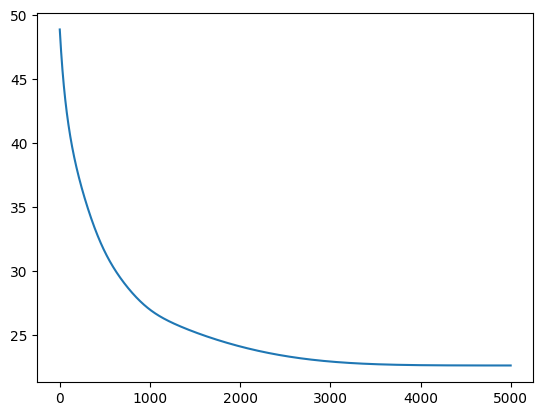

In [19]:
params = {
    "log_scale": jnp.log(0.1),
    "log_var": jnp.log(1.0),
    "log_noise_var": jnp.log(0.1),
}

def loss_fn(params, X, y):
    return jax.vmap(neg_log_likelihood, in_axes=(None, 0, 0))(params, X, y).mean()

value_and_grad_fn = jax.value_and_grad(loss_fn)
opt = optax.adam(1e-3)
state = opt.init(params)
n_epochs = 5000

def one_step(params_and_state, aux):
    params, state = params_and_state
    value, grads = value_and_grad_fn(params, X, y)
    updates, new_state = opt.update(grads, state)
    new_params = optax.apply_updates(params, updates)
    return (new_params, new_state), value

(final_params, _), losses = jax.lax.scan(one_step, (params, state), None, length=n_epochs)
plt.plot(losses);

## Get pre-AL prediction results

In [20]:
test_ds = clean_ds.sel(location_id=np.concatenate([deployed_locations, test_locations]), datetime=slice("2021-07-16", "2021-07-31"))

result_list = []
for time in tqdm(test_ds.datetime.values):
    tmp_ds = test_ds.sel(datetime=time)
    tmp_ds = tmp_ds.dropna(dim="location_id")
    
    available_deployed_locations = np.intersect1d(deployed_locations, tmp_ds.location_id.values)
    tmp_context = tmp_ds.sel(location_id=available_deployed_locations)
    available_test_locations = np.intersect1d(test_locations, tmp_ds.location_id.values)
    tmp_target = tmp_ds.sel(location_id=available_test_locations)
    
    X_context = jnp.stack([tmp_context.lat.values, tmp_context.lon.values], axis=1)
    y_context = jnp.array(tmp_context.value.values)
    X_target = jnp.stack([tmp_target.lat.values, tmp_target.lon.values], axis=1)
    y_target = jnp.array(tmp_target.value.values)
    
    gp = get_gp(final_params, X_context)
    pred_gp = gp.condition(y_context, X_target).gp
    pred_mean = pred_gp.mean
    res_df = pd.DataFrame({
        "time": np.repeat(time, len(X_target)),
        "lat": X_target[:, 0],
        "lon": X_target[:, 1],
        "location_id": tmp_target.location_id.values,
        "value": y_target * std_val + mean_val,
        "pred": pred_mean * std_val + mean_val,
    })
    result_list.append(res_df)

100%|██████████| 381/381 [01:39<00:00,  3.84it/s]


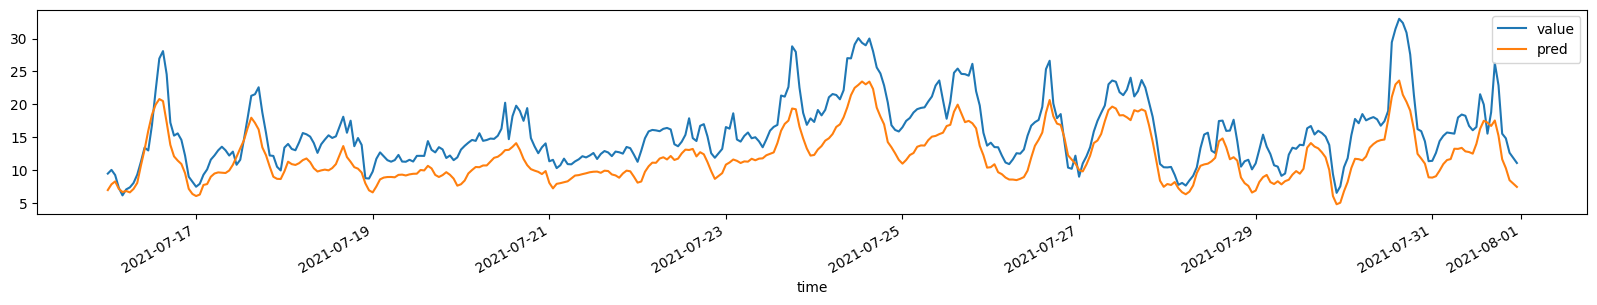

In [21]:
final_df = pd.concat(result_list).set_index(["time"], drop=False).sort_index()
random_location = final_df.location_id.sample().item()
final_df[final_df["location_id"] == random_location].plot(x="time", y=["value", "pred"], figsize=(20, 3));

In [24]:
rmse = mean_squared_error(final_df["value"], final_df["pred"], squared=False)
adjusted = final_df["value"].values
adjusted[adjusted < 0.1] = 0.1
mape = mean_absolute_percentage_error(adjusted, final_df["pred"])
pd.DataFrame({"rmse": [rmse], "mape": [mape]})

,rmse,mape
0,4.711835,3.128352


## Sensor placement with AL

In [23]:
pool_ds = clean_ds.sel(location_id=pool_locations+deployed_locations, datetime=slice("2021-07-01", "2021-07-15"))
pool_ds

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U21'), dtype('<U21')) -> None

In [ ]:
import numpy as np
import regdata as rd

data = rd.SineNoisy()
print(data.X.shape, data.y.shape, data.X_test.shape, data.f(np.array([[0.1], [0.5]])).shape)

(100, 1) (100, 1) (200, 1) (2, 1)
